### **Dataset:** 
Sentiment140 : discover the sentiment of a brand, product, or topic on Twitter.: http://help.sentiment140.com/for-students
    

### **Read data** 

#### Import librairies

In [1]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from termcolor import colored

#### Load data

In [4]:
# Read dataset
dataset = pd.read_csv('Tweets.csv')
dataset.sample(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
145,569609971383586817,negative,1.0000,Cancelled Flight,1.0000,Virgin America,NaN,mlorenzen,NaN,0,@VirginAmerica I paid the premium to fly you a...,NaN,2015-02-22 13:29:34 -0800,"iPhone: 29.741360,-90.131523",Pacific Time (US & Canada)
5979,568448265441554432,negative,1.0000,Flight Attendant Complaints,0.6559,Southwest,NaN,erin_gilley,NaN,0,@SouthwestAir RUDE gate agent. Wholly unaccept...,NaN,2015-02-19 08:33:22 -0800,NaN,NaN
3345,568508151852457985,negative,0.3401,Late Flight,0.3401,United,NaN,jttorrey,NaN,0,@united As it always is. Helps to communicate ...,NaN,2015-02-19 12:31:20 -0800,NaN,Pacific Time (US & Canada)
6878,570066859330019329,negative,0.6570,Can't Tell,0.6570,Delta,NaN,djcheros,NaN,0,@JetBlue you can do better than this. And you ...,NaN,2015-02-23 19:45:05 -0800,"Portland, Maine",Eastern Time (US & Canada)
10279,569400188491730945,negative,1.0000,Cancelled Flight,0.6201,US Airways,NaN,JabbarLewis,NaN,0,@USAirways my flight is Cancelled Flightled an...,NaN,2015-02-21 23:35:58 -0800,"Little Falls, NJ",Central Time (US & Canada)


#### Shape and information of dataset

In [5]:
dataset.shape

(14640, 15)

In [6]:
dataset.info

<bound method DataFrame.info of                  tweet_id airline_sentiment  airline_sentiment_confidence  \
0      570306133677760513           neutral                        1.0000   
1      570301130888122368          positive                        0.3486   
2      570301083672813571           neutral                        0.6837   
3      570301031407624196          negative                        1.0000   
4      570300817074462722          negative                        1.0000   
...                   ...               ...                           ...   
14635  569587686496825344          positive                        0.3487   
14636  569587371693355008          negative                        1.0000   
14637  569587242672398336           neutral                        1.0000   
14638  569587188687634433          negative                        1.0000   
14639  569587140490866689           neutral                        0.6771   

               negativereason  negativereas

In [7]:
dataset.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [8]:
dataset.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [9]:
dataset['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

#### Plot data

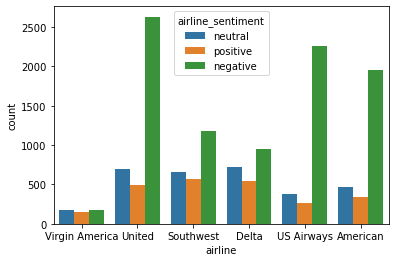

In [10]:
sns.countplot(data = dataset, x ="airline", hue = "airline_sentiment");

### **Data processing**

The values in the target data are categorical and are 'neutral', 'positive' & 'negative'. For the easy computation, we are replacing the 'neutral', 'positive' & 'negative' with 0, 1 & -1 values respectively.

In [11]:
dataset['airline_sentiment'].replace(('neutral', 'positive', 'negative'), (0, 1, -1), inplace=True)
dataset['airline_sentiment'].value_counts()

-1    9178
 0    3099
 1    2363
Name: airline_sentiment, dtype: int64

In [12]:
data_text = dataset['text']
data_text.head()

0                  @VirginAmerica What @dhepburn said.
1    @VirginAmerica plus you've added commercials t...
2    @VirginAmerica I didn't today... Must mean I n...
3    @VirginAmerica it's really aggressive to blast...
4    @VirginAmerica and it's a really big bad thing...
Name: text, dtype: object

In [13]:
data_target = dataset['airline_sentiment']
data_target.head()

0    0
1    1
2    0
3   -1
4   -1
Name: airline_sentiment, dtype: int64

In [14]:
from nltk.corpus import stopwords
STOPWORDS=stopwords.words('english')
STOPWORDS[:5]

['i', 'me', 'my', 'myself', 'we']

In [15]:
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data_text = data_text.apply(lambda text: cleaning_stopwords(text))
data_text.sample(5)

14035    @AmericanAir checking flight website easy aski...
514      @united flying gla-mco weeks. How long airport...
1433         @united How I get @TSA finally board UA 1534?
1792     @united - changed depart 1:45 2:00pm &amp; 1:4...
10055    @USAirways @JosephTReis Dont bother. They dont...
Name: text, dtype: object

In [17]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data_text = data_text.apply(lambda x: cleaning_punctuations(x))
data_text.sample(5)

6394     SouthwestAir  total win Happy 7th bday interco...
13577    AmericanAir Hey whats happening AA65 Zurich  J...
4058     united amazing flying 25000 miles UnitedAirlin...
4633     SouthwestAir LUV new Luv Television Commercial...
14478    AmericanAir Nicest people ever flight ChicagoT...
Name: text, dtype: object

In [22]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
data_text = data_text.apply(lambda x: cleaning_repeating_char(x))
data_text.head()

0                     VirginAmerica What dhepburn said
1    VirginAmerica plus added commercials experienc...
2    VirginAmerica I today Must mean I need take an...
3    VirginAmerica really aggressive blast obnoxiou...
4                   VirginAmerica really big bad thing
Name: text, dtype: object

In [23]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
data_text = data_text.apply(lambda x: cleaning_URLs(x))
data_text.head()


0                     VirginAmerica What dhepburn said
1    VirginAmerica plus added commercials experienc...
2    VirginAmerica I today Must mean I need take an...
3    VirginAmerica really aggressive blast obnoxiou...
4                   VirginAmerica really big bad thing
Name: text, dtype: object

In [24]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
data_text = data_text.apply(lambda x: cleaning_numbers(x))
data_text.head()

0                     VirginAmerica What dhepburn said
1    VirginAmerica plus added commercials experienc...
2    VirginAmerica I today Must mean I need take an...
3    VirginAmerica really aggressive blast obnoxiou...
4                   VirginAmerica really big bad thing
Name: text, dtype: object

In [25]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
data_text = data_text.apply(lambda x: stemming_on_text(x))
data_text.head()

0                     VirginAmerica What dhepburn said
1    VirginAmerica plus added commercials experienc...
2    VirginAmerica I today Must mean I need take an...
3    VirginAmerica really aggressive blast obnoxiou...
4                   VirginAmerica really big bad thing
Name: text, dtype: object

In [29]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package wordnet to /home/thi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/thi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [33]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
data_text = data_text.apply(lambda x: lemmatizer_on_text(x))
data_text.head()


0                     VirginAmerica What dhepburn said
1    VirginAmerica plus added commercials experienc...
2    VirginAmerica I today Must mean I need take an...
3    VirginAmerica really aggressive blast obnoxiou...
4                   VirginAmerica really big bad thing
Name: text, dtype: object

In [34]:
X=data_text
X.sample(5)


8794     JetBlue TV Wifi spotty Its nice feature X coun...
7945     JetBlue saved day Expedia lost costumer jetblu...
13291    AmericanAir airline united Ive spent three ext...
4722     SouthwestAir thank great customer service Tryi...
14041    AmericanAir food served AA vile grossThe entir...
Name: text, dtype: object